# LOGISTIC REGRESSION

## DOCUMENT PREAMBLE

In [1]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from imblearn.over_sampling import RandomOverSampler

# Configure matplotlib
plt.style.use("classic")
#plt.rcParams["figure.dpi"] = 200
plt.rcParams["figure.facecolor"] = "white"
plt.rcParams["font.family"] = "serif"

In [2]:
# Load data from parquet files
def load_data(version, data_type, print_info=False):
    base_path = f"./data_processed/{version}_{data_type}_"
    files = ["behaviors_df_expanded.parquet", "history_df_expanded.parquet", "articles_df_expanded.parquet", "users_df_expanded.parquet"]
    dataframes = [pd.read_parquet(f"{base_path}{file}") for file in files]
    
    if print_info:
        for df in dataframes:
            print(df.info(), "\n")
    
    return dataframes

# Set parameters and load data
version = "small"
data_type = "train"
behaviors_df, history_df, articles_df, users_df = load_data(version, data_type, print_info=False)

In [3]:
# Merge dataframes
initial_row_count = behaviors_df.shape[0]
df = pd.merge(pd.merge(behaviors_df, articles_df, left_on='impression_article_id_inview', right_on='article_id', how='inner'), users_df, on='user_id', how='inner')
final_row_count = df.shape[0]
total_dropped_percentage = ((initial_row_count - final_row_count) / initial_row_count) * 100
print(f"Number of rows dropped due to merge: {(initial_row_count - final_row_count)} ({total_dropped_percentage:.2f}%)")

Number of rows dropped: 11 (0.00%)


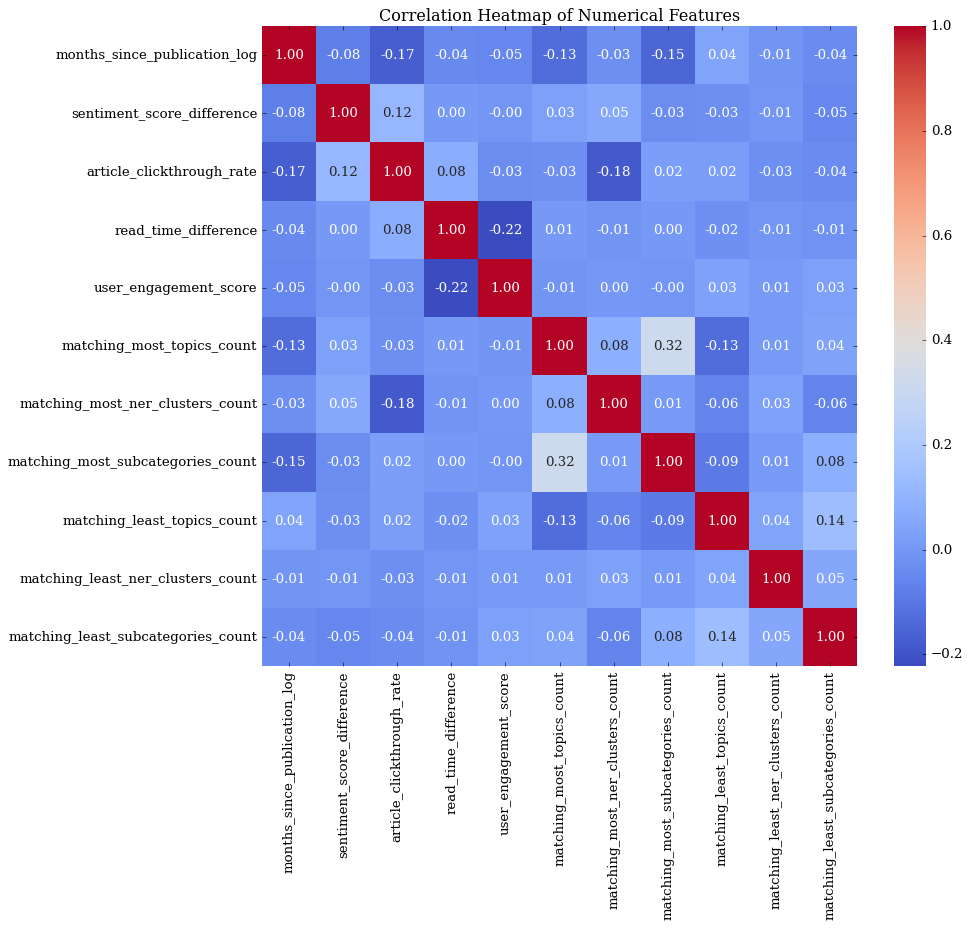

In [4]:
# Feature engineering
df['months_since_publication'] = ((df['impression_time'].dt.year - df['article_published_time'].dt.year) * 12 + (df['impression_time'].dt.month - df['article_published_time'].dt.month))
df['months_since_publication_log'] = np.log1p(df['months_since_publication'])
df['sentiment_score_difference'] = df['article_sentiment_score'] - df['user_avg_sentiment_score']
df['article_clickthrough_rate'] = df['article_total_pageviews'] / df['article_total_inviews']
df['matching_most_topics_count'] = df.apply(lambda row: sum(topic in row['user_most_topics'] for topic in row['article_topics']), axis=1)
df['matching_most_ner_clusters_count'] = df.apply(lambda row: sum(cluster in row['user_most_ner_clusters'] for cluster in row['article_ner_clusters']), axis=1)
df['matching_most_subcategories_count'] = df.apply(lambda row: sum(subcat in row['user_most_subcategories'] for subcat in row['article_subcategory']), axis=1)
df['matching_least_topics_count'] = df.apply(lambda row: sum(topic in row['user_least_topics'] for topic in row['article_topics']), axis=1)
df['matching_least_ner_clusters_count'] = df.apply(lambda row: sum(cluster in row['user_least_ner_clusters'] for cluster in row['article_ner_clusters']), axis=1)
df['matching_least_subcategories_count'] = df.apply(lambda row: sum(subcat in row['user_least_subcategories'] for subcat in row['article_subcategory']), axis=1)
df['article_avg_read_time'] = df['article_total_read_time'] / df['article_total_inviews']
df['read_time_difference'] = df['article_avg_read_time'] - df['user_avg_read_time']
df['user_engagement_score'] = df['impression_read_time'] * df['impression_scroll_percentage'] * (df['impression_article_id_clicked'] + 1)
df['premium_article_premium_user'] = df.apply(lambda row: 0 if row['article_is_premium'] and not row['user_is_subscriber'] else 1, axis=1)

# Plot correlation heatmap
numerical_features = [
    'months_since_publication_log', 'sentiment_score_difference', 'article_clickthrough_rate', 'read_time_difference',
    'user_engagement_score', 'matching_most_topics_count', 'matching_most_ner_clusters_count', 'matching_most_subcategories_count',
    'matching_least_topics_count', 'matching_least_ner_clusters_count', 'matching_least_subcategories_count'
]
plt.figure(figsize=(12, 10))
sns.heatmap(df[numerical_features].corr(), annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Heatmap of Numerical Features')
plt.show()

In [5]:
# Drop rows with missing values
initial_nan_rows = df.isna().any(axis=1).sum()
df.dropna(inplace=True)
rows_dropped = initial_nan_rows
percentage_dropped = (rows_dropped / (df.shape[0] + rows_dropped)) * 100
print(f"Number of rows dropped due to missing values: {rows_dropped} ({percentage_dropped:.2f}%)")

Number of rows dropped due to missing values: 247490 (10.98%)


In [6]:
# Define features and target
features = numerical_features + ['premium_article_premium_user']
target = 'target'

# Fix class imbalance
X_resampled, y_resampled = RandomOverSampler(random_state=42).fit_resample(df[features], df[target])

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.2, random_state=42, stratify=y_resampled)

# Preprocessing pipeline
preprocessor = ColumnTransformer(
    transformers=[
        ('num', MinMaxScaler(), numerical_features),
        ('cat', OneHotEncoder(), ['premium_article_premium_user'])
    ]
)

# Define the parameter grid
param_grid = {
    'classifier__C': [0.01, 0.1, 1, 10, 100],
    'classifier__penalty': ['l1', 'l2']
}

# Function to evaluate the model
def evaluate_model(pipeline, X_train, y_train, X_test, y_test, df, features):
    # Fit the pipeline on the training data
    pipeline.fit(X_train, y_train)
    
    # Predict probabilities for the entire dataframe
    df['predicted_probability'] = pipeline.predict_proba(df[features])[:, 1]
    
    # Get the index of the maximum probability for each impression_id
    idx_max_prob = df.groupby('impression_id')['predicted_probability'].idxmax()
    
    # Get the predicted clicked articles
    predicted_clicks = df.loc[idx_max_prob, ['impression_id', 'impression_article_id_inview']]
    predicted_clicks = predicted_clicks.rename(columns={'impression_article_id_inview': 'predicted_clicked_article'})
    
    # Merge the predicted clicks with the original dataframe
    df = df.merge(predicted_clicks, on='impression_id', how='left')
    
    # Determine if the prediction was correct
    df['correct_prediction'] = df['predicted_clicked_article'] == df['impression_article_id_clicked']
    
    # Calculate evaluation metrics
    accuracy = df['correct_prediction'].mean()
    precision = precision_score(df[target], df['correct_prediction'], zero_division=0)
    recall = recall_score(df[target], df['correct_prediction'], zero_division=0)
    f1 = f1_score(df[target], df['correct_prediction'], zero_division=0)
    roc_auc = roc_auc_score(df[target], df['predicted_probability'])
    
    return accuracy, precision, recall, f1, roc_auc

# Perform grid search
best_score = 0
best_params = None
for C in param_grid['classifier__C']:
    for penalty in param_grid['classifier__penalty']:
        pipeline = Pipeline(
            steps=[
                ('preprocessor', preprocessor),
                ('classifier', LogisticRegression(solver='liblinear', class_weight='balanced', C=C, penalty=penalty))
            ]
        )
        accuracy, precision, recall, f1, roc_auc = evaluate_model(pipeline, X_train, y_train, X_test, y_test, df, features)
        if roc_auc > best_score:
            best_score = roc_auc
            best_params = {'C': C, 'penalty': penalty}
        print(f"Parameters: C={C}, penalty={penalty} -> ROC AUC: {roc_auc:.4f}")

# Print best parameters and best score
print(f"Best parameters: {best_params}")
print(f"Best ROC AUC score: {best_score:.4f}\n")

# Use the best estimator to predict probabilities and evaluate
best_pipeline = Pipeline(
    steps=[
        ('preprocessor', preprocessor),
        ('classifier', LogisticRegression(solver='liblinear', class_weight='balanced', **best_params))
    ]
)
accuracy, precision, recall, f1, roc_auc = evaluate_model(best_pipeline, X_train, y_train, X_test, y_test, df, features)

# Cross-validation
cv_scores = cross_val_score(best_pipeline, X_resampled, y_resampled, cv=5, scoring='roc_auc')

# Calculate average number of articles per session
avg_articles_per_session = df.groupby('impression_id').size().mean()

# Print evaluation metrics and comparison with random guessing
print(f'Accuracy: {accuracy:.4f}')
print(f'Precision: {precision:.4f}')
print(f'Recall: {recall:.4f}')
print(f'F1 Score: {f1:.4f}')
print(f'ROC AUC: {roc_auc:.4f}')
print(f'Cross-validated ROC AUC: {cv_scores.mean():.4f}\n')
print(f'Average number of articles per session: {avg_articles_per_session:.2f}')
print(f'Random guessing accuracy: {1 / avg_articles_per_session:.4f}')

Parameters: C=0.01, penalty=l1 -> ROC AUC: 0.6605
Parameters: C=0.01, penalty=l2 -> ROC AUC: 0.6606
Parameters: C=0.1, penalty=l1 -> ROC AUC: 0.6605
Parameters: C=0.1, penalty=l2 -> ROC AUC: 0.6605
Parameters: C=1, penalty=l1 -> ROC AUC: 0.6605
Parameters: C=1, penalty=l2 -> ROC AUC: 0.6605
Parameters: C=10, penalty=l1 -> ROC AUC: 0.6605
Parameters: C=10, penalty=l2 -> ROC AUC: 0.6605
Parameters: C=100, penalty=l1 -> ROC AUC: 0.6605
Parameters: C=100, penalty=l2 -> ROC AUC: 0.6605
Best parameters: {'C': 0.01, 'penalty': 'l2'}
Best ROC AUC score: 0.6606

Accuracy: 0.1626
Precision: 0.1367
Recall: 0.2204
F1 Score: 0.1688
ROC AUC: 0.6606
Cross-validated ROC AUC: 0.6504

Average number of articles per session: 9.78
Random guessing accuracy: 0.1023


```
Accuracy: 0.1668
Precision: 0.1345
Recall: 0.2256
F1 Score: 0.1685
ROC AUC: 0.6640
Cross-validated ROC AUC: 0.6536

Average number of articles per session: 9.91
Random guessing accuracy: 0.1009
```

(Results using `small` dataset)

**Explanation of Results**:

* **Accuracy** (16.26%): The model correctly predicts the clicked article 16.26% of the time, better than random guessing (10.23%).

* **Precision** (13.67%): When the model predicts an article as clicked, it is correct 13.67% of the time.

* **Recall** (22.04%): The model correctly identifies 22.04% of the actual clicked articles.

* **F1 Score** (16.88%): The balance between precision and recall is 16.88%.

* **ROC AUC** (66.06%): The model has a 66.06% chance of correctly distinguishing between clicked and non-clicked articles, better than random guessing (50%).

* **Cross-validated ROC AUC** (65.04%): Consistent performance across different data subsets.

* **Average Articles per Session** (9.78): On average, there are about 9.78 articles per session.

* **Random Guessing Accuracy** (10.23%): Randomly guessing the clicked article would be correct 10.23% of the time.

**Interpretation**:

The model's accuracy (16.26%) is better than random guessing (10.23%), indicating it learns patterns in the data.

The ROC AUC score (66.06%) shows the model is better than random at distinguishing clicked articles.

Precision, recall, and F1 scores are low, suggesting room for improvement through better features, more complex models, hyperparameter tuning, and data augmentation.